<a href="https://colab.research.google.com/github/kittisaktaoma/colab_practice/blob/master/CalcSynergy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Library 



In [ ]:
! wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
! chmod +x Miniconda3-latest-Linux-x86_64.sh
! ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
! conda config --set always_yes yes --set changeps1 no
! conda install -q -y -c conda-forge python=3.7
! conda install -q -y -c conda-forge rdkit==2020.09.2 

In [2]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from rdkit import Chem

In [ ]:
! pip install keras
! pip install tensorflow
! pip install keras-gcn
! pip install numpy
! pip install matplotlib
! pip install scipy
! pip install deepchem
! pip install keras-tuner
! pip install pubchempy
! pip install chembl_webresource_client

In [4]:
import deepchem as dc
import tensorflow as tf
import tensorflow.keras.layers as layers
import pandas as pd
import numpy as np
import deepchem as dc
from rdkit import Chem
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import BayesianOptimization
from chembl_webresource_client.new_client import new_client
import tensorflow as tf
from tensorflow.keras.backend import variable, dot as k_dot, sigmoid, relu
from tensorflow.keras.layers import Dense, Input, Concatenate, Layer
import numpy as np
import urllib
import pubchempy as pcp
import random 
import kerastuner as kt
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.pooling import MaxPooling1D
from keras.layers.merge import concatenate
from keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hypermodel import HyperModel
from kerastuner.engine.hyperparameters import HyperParameters
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D
)

#Toy data

In [5]:
sample_01 = pd.read_csv("https://raw.githubusercontent.com/kittisaktaoma/colab_practice/master/sample.txt",sep="\t").iloc[:,1]
sample_02 = pd.read_csv("https://raw.githubusercontent.com/kittisaktaoma/colab_practice/master/sample.txt",sep="\t").iloc[:,2]
all_sample = sample_01.append(sample_02).unique()
all_sample[:20]

array(['5-FU', 'ABT-888', 'AZD1775', 'BEZ-235', 'BORTEZOMIB',
       'CARBOPLATIN', 'CYCLOPHOSPHAMIDE', 'DASATINIB', 'DEXAMETHASONE',
       'DINACICLIB', 'DOXORUBICIN', 'ERLOTINIB', 'ETOPOSIDE',
       'GELDANAMYCIN', 'GEMCITABINE', 'L778123', 'LAPATINIB', 'METFORMIN',
       'METHOTREXATE', 'MITOMYCINE'], dtype=object)

#Feature Preparation

##Drug structure


In [ ]:
drug_smiles = {}
for i in all_sample:
  try:
    print(i)
    res = pcp.get_compounds(i, 'name')
    SM = res[0].canonical_smiles   
    drug_smiles[i] = SM
  except Exception:
    pass

In [7]:
list(drug_smiles.keys()).__len__()

124

In [8]:
tmp_list = []
feat_mat = {}

curated_df = pd.DataFrame(drug_smiles.items(), columns=['Name', 'smiles'])

for i in range(curated_df.shape[0]):

  """
  create normalize adjacency matrix
  """

  mol = Chem.MolFromSmiles(curated_df.iloc[i,1])
  A = Chem.GetAdjacencyMatrix(mol).tolist()
  I = np.eye(A.__len__())

  A_hat = np.array(A + I)

  """
  create feaature matrix
  #https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html
  """

  f1 = pd.DataFrame([[mol.GetAtomWithIdx(j).GetIsAromatic() for j in range(mol.GetNumAtoms())]]).T
  f2 = pd.DataFrame([[mol.GetAtomWithIdx(j).GetDegree() for j in range(mol.GetNumAtoms())]]).T
  f3 = pd.DataFrame([[mol.GetAtomWithIdx(j).GetImplicitValence() for j in range(mol.GetNumAtoms())]]).T
  f4 = pd.DataFrame([[mol.GetAtomWithIdx(j).GetMass() for j in range(mol.GetNumAtoms())]]).T
  f5 = pd.DataFrame([[mol.GetAtomWithIdx(j).GetNumImplicitHs() for j in range(mol.GetNumAtoms())]]).T

  X = np.array(pd.concat([f1,f2,f3,f4,f5],axis=1)).astype(int)

  """
  multiplication A_hat*X
  """

  tmp_res = A_hat @ X

  """
  Padding matrix
  """

  tmp_list.append(tmp_res)

  if i == (curated_df.shape[0]-1):
      max_atom_number = max([tmp_list[i].__len__() for i in range(curated_df.shape[0])])
      tmp_pad = pad_sequences(tmp_list, padding='post',maxlen=max_atom_number)
      
      for j in range(curated_df.shape[0]):
        feat_mat[curated_df.iloc[j,0]] = tmp_pad[j]

In [48]:
feat_mat

{'1-(5-DEOXYPENTOFURANOSYL)-5-FLUORO-4-{[(PENTYLOXY)CARBONYL]AMINO}PYRIMIDIN-2(1H)-ONE': array([[ 0,  3,  5, 24,  5],
        [ 0,  5,  7, 36,  7],
        [ 0,  6,  6, 36,  6],
        [ 0,  6,  6, 36,  6],
        [ 0,  6,  4, 39,  4],
        [ 0,  7,  2, 39,  2],
        [ 0,  8,  1, 56,  1],
        [ 0,  4,  0, 27,  0],
        [ 1,  8,  1, 38,  1],
        [ 3, 10,  1, 52,  1],
        [ 3,  8,  0, 38,  0],
        [ 3,  9,  0, 55,  0],
        [ 1,  4,  0, 27,  0],
        [ 3, 11,  2, 50,  2],
        [ 3,  8,  1, 38,  1],
        [ 3,  9,  1, 54,  1],
        [ 1,  4,  0, 30,  0],
        [ 1, 11,  2, 53,  2],
        [ 0, 10,  4, 51,  4],
        [ 0, 10,  4, 51,  4],
        [ 0,  9,  5, 51,  5],
        [ 0,  8,  2, 39,  2],
        [ 0,  4,  4, 24,  4],
        [ 0,  4,  2, 27,  2],
        [ 0,  4,  2, 27,  2],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,

##Target protein

In [ ]:
target_protein = {}
for i in all_sample:
  try:
    print(i)
    c = pcp.get_compounds(i, 'name')
    pubmed_query_length = str(c[0].cid).__len__()
    add_length = 8 - int(pubmed_query_length)
    stitch_cid = "CIDs"+ '0'*int(add_length) + str(c[0].cid)
    target_prot = np.array(pd.read_csv("http://stitch.embl.de/api/tsv/interactors?identifier="+stitch_cid+"&species=9606",sep="\t").iloc[1:,:])
    target_protein[i] = target_prot
  except Exception:
    pass

In [ ]:
target_protein

###protein ID conversion

In [ ]:
test = [list(target_protein.values())[i].tolist() for i in range(len(target_protein))]
test_01 = sum(sum(test, []),[])
final = [s.replace('9606.',"") for s in test_01]
len(final)

945

In [ ]:
! pip install stringdb
import stringdb
string_ids = stringdb.get_string_ids(final)
enrichment_df = stringdb.get_enrichment(string_ids.queryItem)
enrichment_df

In [ ]:
PI3K_gene = enrichment_df[enrichment_df.category == "KEGG"]
PI3K_gene.sort_values("number_of_genes",ascending = False)

,category,term,number_of_genes,number_of_genes_in_background,ncbiTaxonId,inputGenes,preferredNames,p_value,fdr,description
3533,KEGG,hsa05200,129,515,9606,"ENSP00000211122,ENSP00000215832,ENSP0000021611...","GSTA3,MAPK1,HMOX1,TGFB1,HGF,RPS6KB1,IL2,CCND1,...",7.780000e-83,2.100000e-80,Pathways in cancer
3534,KEGG,hsa04151,83,348,9606,"ENSP00000215832,ENSP00000222390,ENSP0000022547...","MAPK1,HGF,CSF3,RPS6KB1,IL2,CCND1,IL4,FLT3,RAF1...",7.320000e-51,9.880000e-49,PI3K-Akt signaling pathway
3600,KEGG,hsa01100,80,1250,9606,"ENSP00000001146,ENSP00000216117,ENSP0000021742...","CYP26B1,HMOX1,AHCY,CYP3A5,GAPDH,AMPD2,CYP2C9,C...",2.240000e-14,8.910000e-14,Metabolic pathways
3544,KEGG,hsa05165,58,317,9606,"ENSP00000080059,ENSP00000215832,ENSP0000022557...","HDAC7,MAPK1,RPS6KB1,CCND1,TUBG1,RAF1,KRAS,CDK4...",4.060000e-30,9.140000e-29,Human papillomavirus infection
3537,KEGG,hsa05205,52,195,9606,"ENSP00000215832,ENSP00000221930,ENSP0000022239...","MAPK1,TGFB1,HGF,RPS6KB1,CCND1,SMO,RAF1,KRAS,MD...",6.780000e-34,3.660000e-32,Proteoglycans in cancer
...,...,...,...,...,...,...,...,...,...,...
3714,KEGG,hsa00770,3,19,9606,"ENSP00000276651,ENSP00000354238,ENSP00000359211","DPYS,ENPP1,DPYD",1.520000e-02,2.260000e-02,Pantothenate and CoA biosynthesis
3716,KEGG,hsa00670,3,20,9606,"ENSP00000315644,ENSP00000319170,ENSP00000396308","TYMS,DHFRL1,DHFR",1.720000e-02,2.520000e-02,One carbon pool by folate
3722,KEGG,hsa00592,3,25,9606,"ENSP00000312286,ENSP00000333142,ENSP00000356436","PLA2G1B,PLA2G6,PLA2G4A",2.910000e-02,4.140000e-02,alpha-Linolenic acid metabolism
3692,KEGG,hsa00232,3,5,9606,"ENSP00000301141,ENSP00000342007,ENSP00000368727","CYP2A6,CYP1A2,XDH",7.100000e-04,1.200000e-03,Caffeine metabolism


In [ ]:
PI3K_gene_list = PI3K_gene.iloc[1,5].split(",")
PI3K_gene_list_02 = ["9606."+i for i in PI3K_gene_list]
PI3K_gene_list_02.__len__()

83

In [ ]:
tmp_dict = {}

for i in range(len(target_protein)):
  query_list = set(sum(list(target_protein.values())[i].tolist(),[]))
  ref_list = set(PI3K_gene_list_02)
  res_list = list(query_list & ref_list)
  tmp_dict[list(target_protein.keys())[i]] = res_list


In [ ]:
res_tmp = pd.DataFrame(tmp_dict.items())


,0,1
0,5-FU,"[9606.ENSP00000276927, 9606.ENSP00000269305, 9..."
1,ABT-888,"[9606.ENSP00000418960, 9606.ENSP00000275493]"
2,AZD1775,[]
3,BEZ-235,"[9606.ENSP00000263967, 9606.ENSP00000354558, 9..."
4,BORTEZOMIB,"[9606.ENSP00000269305, 9606.ENSP00000376943]"
...,...,...
117,RUXOLITINIB,"[9606.ENSP00000343204, 9606.ENSP00000371067, 9..."
118,VANDETANIB,"[9606.ENSP00000263923, 9606.ENSP00000275493, 9..."
119,NSC707389,[]
120,NSC256439,[]


##Boolean

In [ ]:
# Some code to return a Pandas dataframe, given tabular text

def to_df(result):
    return pd.read_table(io.StringIO(result), header=None)

#! pip install Bio
from Bio.KEGG import REST
from Bio.KEGG.KGML import KGML_parser
import pandas as pd
import io

result = REST.kegg_link("hsa", "hsa04151").read()
to_df(result)


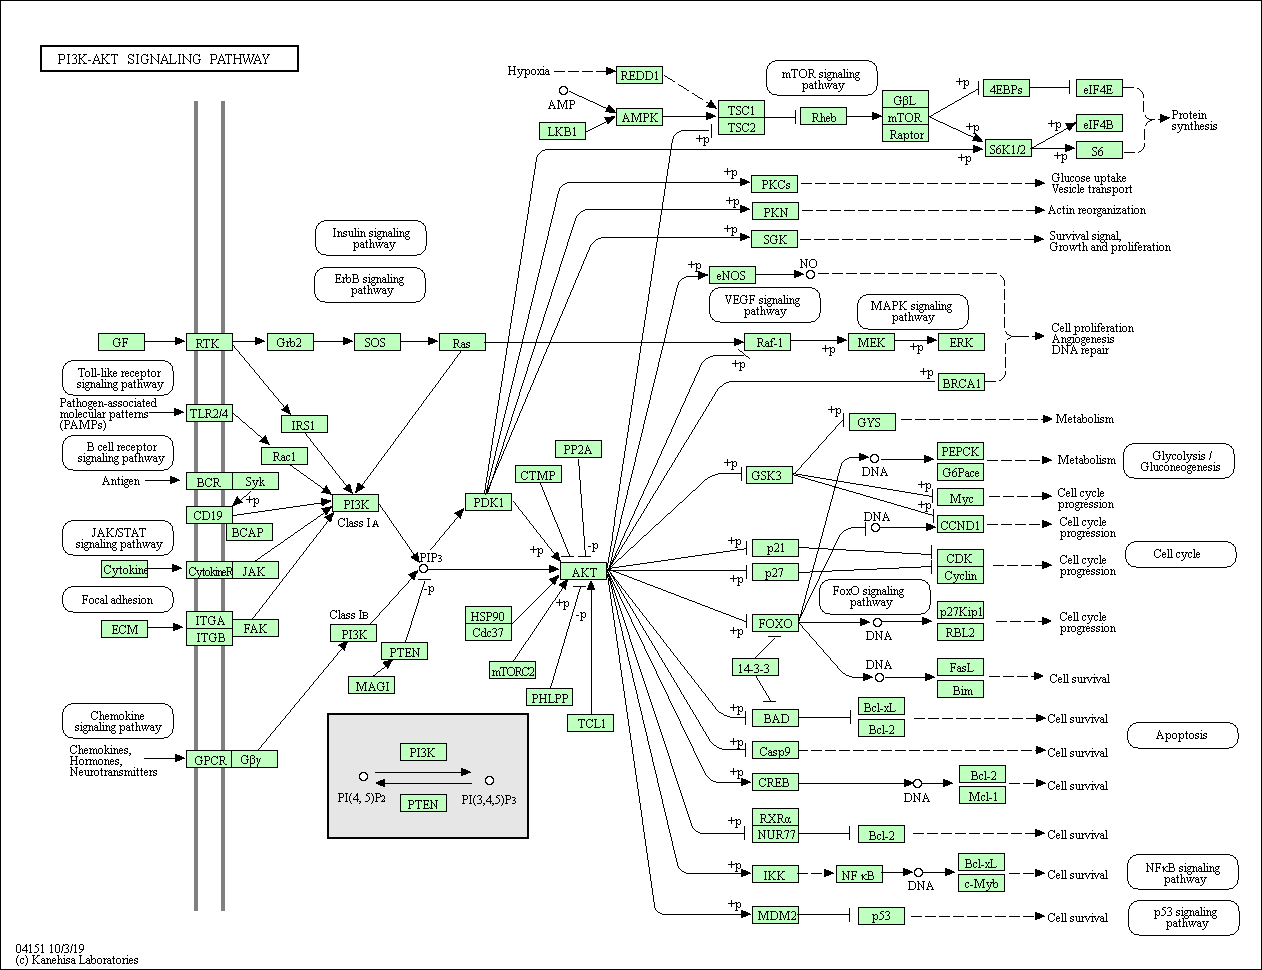

In [ ]:
from IPython.display import Image
from Bio.KEGG.KGML.KGML_parser import read
s = REST.kegg_get("hsa04151","image").read()
Image(s)

In [ ]:
s = REST.kegg_get("hsa04151","kgml").read()
print(s)

In [ ]:
from IPython.display import Image
from Bio.KEGG.KGML.KGML_parser import read
import random
s = REST.kegg_get("hsa04151","kgml").read()
tmp_list = [str(read(s).relations[i]) for i in range(read(s).relations.__len__())]

In [ ]:
tmp_list[0].split("\n")
#read(s).relations.__len__()

['Relation (subtypes: 1):',
 'Entry1:',
 'Entry node ID: 199',
 'Names: hsa:3716 hsa:3717 hsa:3718',
 'Type: gene',
 'Components: set()',
 'Reactions: ',
 'Graphics elements: 1 [<Bio.KEGG.KGML.KGML_pathway.Graphics object at 0x7fa165460be0>]',
 '',
 'Entry2:',
 'Entry node ID: 19',
 'Names: hsa:5290 hsa:5291 hsa:5293 hsa:5295 hsa:5296 hsa:8503',
 'Type: gene',
 'Components: set()',
 'Reactions: ',
 'Graphics elements: 1 [<Bio.KEGG.KGML.KGML_pathway.Graphics object at 0x7fa165338908>]',
 '',
 'Subtype: activation',
 '-->']

In [ ]:
dict_kegg_tmp = []

for i in range(read(s).relations.__len__()):
  try:
    node_1 = tmp_list[i].split("\n")[3]
    node_1_type = tmp_list[i].split("\n")[4]
    node_2 = tmp_list[i].split("\n")[11]
    node_2_type = tmp_list[i].split("\n")[12]
    relations = tmp_list[i].split("\n")[18]
    tmp_res_02 = [node_2,"=",node_1,"[","Relation:",relations,"and type:" ,node_1_type,"&",node_2_type,"]"] 
    res_bool = " ".join(tmp_res_02).replace("Names:","").replace("Type:","")
    open("Boolean_final.txt","a").write(res_bool + "\n")
  except Exception:
    pass

In [ ]:
d = open("test_03.txt", "r")
d.read()

'PPrel -->  hsa:3164 =  hsa:100533105 hsa:10110 hsa:23678 hsa:6446\nPPrel --|  hsa:23035 hsa:23239 =  hsa:2997 hsa:2998\nPPrel -->  undefined =  hsa:10000 hsa:207 hsa:208\nPPrel -->  undefined =  hsa:6009\nPPrel -->  cpd:C05981 =  hsa:596\nPPrel --|  hsa:1436 hsa:1956 hsa:1969 hsa:2064 hsa:2065 hsa:2066 hsa:2260 hsa:2261 hsa:2263 hsa:2264 hsa:2321 hsa:2322 hsa:2324 hsa:3480 hsa:3643 hsa:3791 hsa:3815 hsa:4233 hsa:4804 hsa:4914 hsa:4915 hsa:5156 hsa:5159 hsa:7010 =  hsa:595\nPPrel -->  hsa:6198 hsa:6199 =  cpd:C05981\nGErel --|  undefined =  hsa:596\nGErel -->  hsa:2309 =  hsa:5170\nGErel --|  hsa:10000 hsa:207 hsa:208 =  hsa:10000 hsa:207 hsa:208\nPPrel -->  hsa:572 =  hsa:5562 hsa:5563\nPPrel -->  hsa:2309 =  hsa:4193\nPPrel -->  hsa:4193 =  hsa:1978\nPPrel -->  hsa:28227 hsa:55012 hsa:5515 hsa:5516 hsa:5518 hsa:5519 hsa:5520 hsa:5521 hsa:5522 hsa:5523 hsa:5525 hsa:5526 hsa:5527 hsa:5528 hsa:5529 hsa:55844 =  hsa:4193\nPPrel -->  hsa:3164 =  hsa:672\nGErel -->  hsa:3265 hsa:3845 hsa:4

##Cell line

# Data Preparation

In [24]:
df_model = pd.read_csv("https://raw.githubusercontent.com/kittisaktaoma/colab_practice/master/sample.txt",sep="\t").iloc[:,np.r_[1,2,6]]
df_model

,drug_row,drug_col,synergy_loewe
0,5-FU,ABT-888,-10.71
1,5-FU,ABT-888,-12.55
2,5-FU,ABT-888,-4.03
3,5-FU,ABT-888,-9.40
4,5-FU,AZD1775,-1.11
...,...,...,...
45610,VISMODEGIB,ADM HYDROCHLORIDE,-2.56
45611,CRIZOTINIB,ADM HYDROCHLORIDE,-19.71
45612,CABAZITAXEL,ADM HYDROCHLORIDE,-8.26
45613,VANDETANIB,ADM HYDROCHLORIDE,2.77


##Intersect detectable drug from all feature

In [23]:
#target protein & drug structure
available_drug = list(target_protein.keys() & feat_mat.keys())
len(available_drug)

122

In [52]:
target_protein_01 = {k: target_protein[k] for k in set(available_drug) & set(target_protein.keys())}
drug_number = list(target_protein_01.values()).__len__()
newDF = pd.DataFrame() 

for i in range(drug_number):
  df_annotated = pd.DataFrame(pd.DataFrame(list(target_protein_01.values())[i].tolist()))
  df_annotated["drug"] = list(target_protein_01.keys())[i]
  newDF = df_annotated.append(newDF)
newDF.columns = ['protein','drug']
newDF

,protein,drug
0,9606.ENSP00000361125,THALIDOMIDE
1,9606.ENSP00000264498,THALIDOMIDE
2,9606.ENSP00000398698,THALIDOMIDE
3,9606.ENSP00000231948,THALIDOMIDE
4,9606.ENSP00000306512,THALIDOMIDE
...,...,...
5,9606.ENSP00000270202,CELECOXIB
6,9606.ENSP00000269305,CELECOXIB
7,9606.ENSP00000368438,CELECOXIB
8,9606.ENSP00000285379,CELECOXIB


In [53]:
df_model_02 = df_model.groupby(['drug_row','drug_col']).agg({'synergy_loewe': 'mean'}).reset_index()
df_model_03 = df_model_02[df_model_02.drug_row.isin(newDF.drug.unique().tolist())]
df_model_04 = df_model_03[df_model_03.drug_col.isin(newDF.drug.unique().tolist())]
df_model_04

,drug_row,drug_col,synergy_loewe
105,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,-10.583333
106,5-FLUORO-2'-DEOXYURIDINE,AMINOLEVULINIC ACID HYDROCHLORIDE,-8.270000
107,5-FLUORO-2'-DEOXYURIDINE,ANASTROZOLE,-3.548333
108,5-FLUORO-2'-DEOXYURIDINE,ANTIBIOTIC AD 32,-5.140000
109,5-FLUORO-2'-DEOXYURIDINE,ANTIBIOTIC AY 22989,-6.008333
...,...,...,...
5847,ZOLINZA,TOPOTECAN,4.773750
5848,ZOLINZA,TOPOTECAN HYDROCHLORIDE,-12.246667
5849,ZOLINZA,TRIETHYLENEMELAMINE,1.803333
5850,ZOLINZA,VINBLASTINE SULFATE,-1.546667


###Target Protein

In [54]:
crosstab_df_target_protein = pd.crosstab(newDF["drug"],newDF['protein']).stack().reset_index(name='Freq')
crosstab_df_target_protein_02 = pd.pivot_table(crosstab_df_target_protein,index='drug', columns='protein',values='Freq').reset_index()
crosstab_df_target_protein_03 = crosstab_df_target_protein_02.iloc[:,0:]
crosstab_df_target_protein_03

protein,drug,9606.ENSP00000001008,9606.ENSP00000001146,9606.ENSP00000013807,9606.ENSP00000037502,9606.ENSP00000080059,9606.ENSP00000206249,9606.ENSP00000211122,9606.ENSP00000215832,9606.ENSP00000216117,9606.ENSP00000216330,9606.ENSP00000216714,9606.ENSP00000216911,9606.ENSP00000217133,9606.ENSP00000217185,9606.ENSP00000217426,9606.ENSP00000218032,9606.ENSP00000219431,9606.ENSP00000219700,9606.ENSP00000220764,9606.ENSP00000220809,9606.ENSP00000221130,9606.ENSP00000221930,9606.ENSP00000222390,9606.ENSP00000222982,9606.ENSP00000223095,9606.ENSP00000225474,9606.ENSP00000225577,9606.ENSP00000226413,9606.ENSP00000226730,9606.ENSP00000227507,9606.ENSP00000227758,9606.ENSP00000228682,9606.ENSP00000229135,9606.ENSP00000229239,9606.ENSP00000231449,9606.ENSP00000231509,9606.ENSP00000231790,9606.ENSP00000231948,9606.ENSP00000233146,...,9606.ENSP00000387699,9606.ENSP00000388648,9606.ENSP00000388902,9606.ENSP00000391676,9606.ENSP00000393583,9606.ENSP00000394932,9606.ENSP00000396308,9606.ENSP00000396704,9606.ENSP00000398495,9606.ENSP00000398698,9606.ENSP00000399985,9606.ENSP00000400175,9606.ENSP00000402084,9606.ENSP00000402861,9606.ENSP00000408632,9606.ENSP00000408695,9606.ENSP00000408860,9606.ENSP00000410076,9606.ENSP00000411532,9606.ENSP00000412237,9606.ENSP00000413074,9606.ENSP00000414334,9606.ENSP00000417281,9606.ENSP00000417517,9606.ENSP00000418532,9606.ENSP00000418960,9606.ENSP00000419692,9606.ENSP00000419782,9606.ENSP00000420168,9606.ENSP00000425561,9606.ENSP00000427562,9606.ENSP00000430075,9606.ENSP00000430432,9606.ENSP00000434516,9606.ENSP00000441927,9606.ENSP00000457706,9606.ENSP00000459962,9606.ENSP00000462196,9606.ENSP00000463999,9606.ENSP00000464149
0,5-FLUORO-2'-DEOXYURIDINE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,5-FU,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,ABIRATERONE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,ABT-888,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,ACTINOMYCIN D,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,VINCRISTINE SULFATE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
104,VINORELBINE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
105,VISMODEGIB,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
106,ZOLEDRONIC ACID,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
newDF_prot = pd.DataFrame()

for i in range(df_model_04.shape[0]):
  print(i)
  
  index_drug = df_model_04.iloc[df_model_04.shape[0]-1-i,:2].tolist()
  drug_row = crosstab_df_target_protein_03[crosstab_df_target_protein_03.drug == index_drug[0]]

  drug_row_02 = drug_row.rename(columns={'drug': 'drug_row'})
  drug_col = crosstab_df_target_protein_03[crosstab_df_target_protein_03["drug"] == index_drug[1]]

  drug_col_02 = drug_col.rename(columns={'drug': 'drug_col'})
  res_app = pd.concat([drug_row_02.reset_index(drop=True),drug_col_02.reset_index(drop=True)],axis=1)

  res_app_2 = res_app.sort_index(axis=1).iloc[:,:988]
  res_app_tmp = res_app.sort_index(axis=1).iloc[:,988:]
  
  final_df = pd.concat([res_app_tmp,res_app_2],axis=1)
  newDF_prot = final_df.append(newDF_prot) 

In [56]:
newDF_prot

protein,drug_col,drug_row,9606.ENSP00000001008,9606.ENSP00000001008,9606.ENSP00000001146,9606.ENSP00000001146,9606.ENSP00000013807,9606.ENSP00000013807,9606.ENSP00000037502,9606.ENSP00000037502,9606.ENSP00000080059,9606.ENSP00000080059,9606.ENSP00000206249,9606.ENSP00000206249,9606.ENSP00000211122,9606.ENSP00000211122,9606.ENSP00000215832,9606.ENSP00000215832,9606.ENSP00000216117,9606.ENSP00000216117,9606.ENSP00000216330,9606.ENSP00000216330,9606.ENSP00000216714,9606.ENSP00000216714,9606.ENSP00000216911,9606.ENSP00000216911,9606.ENSP00000217133,9606.ENSP00000217133,9606.ENSP00000217185,9606.ENSP00000217185,9606.ENSP00000217426,9606.ENSP00000217426,9606.ENSP00000218032,9606.ENSP00000218032,9606.ENSP00000219431,9606.ENSP00000219431,9606.ENSP00000219700,9606.ENSP00000219700,9606.ENSP00000220764,9606.ENSP00000220764,...,9606.ENSP00000413074,9606.ENSP00000413074,9606.ENSP00000414334,9606.ENSP00000414334,9606.ENSP00000417281,9606.ENSP00000417281,9606.ENSP00000417517,9606.ENSP00000417517,9606.ENSP00000418532,9606.ENSP00000418532,9606.ENSP00000418960,9606.ENSP00000418960,9606.ENSP00000419692,9606.ENSP00000419692,9606.ENSP00000419782,9606.ENSP00000419782,9606.ENSP00000420168,9606.ENSP00000420168,9606.ENSP00000425561,9606.ENSP00000425561,9606.ENSP00000427562,9606.ENSP00000427562,9606.ENSP00000430075,9606.ENSP00000430075,9606.ENSP00000430432,9606.ENSP00000430432,9606.ENSP00000434516,9606.ENSP00000434516,9606.ENSP00000441927,9606.ENSP00000441927,9606.ENSP00000457706,9606.ENSP00000457706,9606.ENSP00000459962,9606.ENSP00000459962,9606.ENSP00000462196,9606.ENSP00000462196,9606.ENSP00000463999,9606.ENSP00000463999,9606.ENSP00000464149,9606.ENSP00000464149
0,AMIFOSTINE,5-FLUORO-2'-DEOXYURIDINE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
0,AMINOLEVULINIC ACID HYDROCHLORIDE,5-FLUORO-2'-DEOXYURIDINE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
0,ANASTROZOLE,5-FLUORO-2'-DEOXYURIDINE,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
0,ANTIBIOTIC AD 32,5-FLUORO-2'-DEOXYURIDINE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
0,ANTIBIOTIC AY 22989,5-FLUORO-2'-DEOXYURIDINE,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,TOPOTECAN,ZOLINZA,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,TOPOTECAN HYDROCHLORIDE,ZOLINZA,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,TRIETHYLENEMELAMINE,ZOLINZA,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,VINBLASTINE SULFATE,ZOLINZA,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [57]:
newDF_prot_02 = pd.DataFrame() 
i = list(newDF_prot.iloc[:,2:].columns.unique())
for k in i:
  x = pd.DataFrame(newDF_prot.loc[:,k].sum(axis=1))
  x.columns = [k]
  newDF_prot_02 = pd.concat([x,newDF_prot_02],axis=1)
final_df_ordinal = pd.concat([newDF_prot.iloc[:,:2], newDF_prot_02],axis=1)
print(final_df_ordinal)

                             drug_col  ... 9606.ENSP00000001008
0                          AMIFOSTINE  ...                    0
0   AMINOLEVULINIC ACID HYDROCHLORIDE  ...                    0
0                         ANASTROZOLE  ...                    0
0                    ANTIBIOTIC AD 32  ...                    0
0                 ANTIBIOTIC AY 22989  ...                    1
..                                ...  ...                  ...
0                           TOPOTECAN  ...                    0
0             TOPOTECAN HYDROCHLORIDE  ...                    0
0                 TRIETHYLENEMELAMINE  ...                    0
0                 VINBLASTINE SULFATE  ...                    0
0                     ZOLEDRONIC ACID  ...                    0

[4211 rows x 496 columns]


In [58]:
final_df_ordinal.iloc[:,:2]

,drug_col,drug_row
0,AMIFOSTINE,5-FLUORO-2'-DEOXYURIDINE
0,AMINOLEVULINIC ACID HYDROCHLORIDE,5-FLUORO-2'-DEOXYURIDINE
0,ANASTROZOLE,5-FLUORO-2'-DEOXYURIDINE
0,ANTIBIOTIC AD 32,5-FLUORO-2'-DEOXYURIDINE
0,ANTIBIOTIC AY 22989,5-FLUORO-2'-DEOXYURIDINE
...,...,...
0,TOPOTECAN,ZOLINZA
0,TOPOTECAN HYDROCHLORIDE,ZOLINZA
0,TRIETHYLENEMELAMINE,ZOLINZA
0,VINBLASTINE SULFATE,ZOLINZA


In [59]:
score = pd.DataFrame(df_model_04.iloc[:,2]).reset_index(drop=True)
f1 = final_df_ordinal.reset_index(drop=True)
target_protein_df = pd.concat([f1,score],axis=1)
target_protein_df

,drug_col,drug_row,9606.ENSP00000464149,9606.ENSP00000463999,9606.ENSP00000462196,9606.ENSP00000459962,9606.ENSP00000457706,9606.ENSP00000441927,9606.ENSP00000434516,9606.ENSP00000430432,9606.ENSP00000430075,9606.ENSP00000427562,9606.ENSP00000425561,9606.ENSP00000420168,9606.ENSP00000419782,9606.ENSP00000419692,9606.ENSP00000418960,9606.ENSP00000418532,9606.ENSP00000417517,9606.ENSP00000417281,9606.ENSP00000414334,9606.ENSP00000413074,9606.ENSP00000412237,9606.ENSP00000411532,9606.ENSP00000410076,9606.ENSP00000408860,9606.ENSP00000408695,9606.ENSP00000408632,9606.ENSP00000402861,9606.ENSP00000402084,9606.ENSP00000400175,9606.ENSP00000399985,9606.ENSP00000398698,9606.ENSP00000398495,9606.ENSP00000396704,9606.ENSP00000396308,9606.ENSP00000394932,9606.ENSP00000393583,9606.ENSP00000391676,9606.ENSP00000388902,...,9606.ENSP00000233146,9606.ENSP00000231948,9606.ENSP00000231790,9606.ENSP00000231509,9606.ENSP00000231449,9606.ENSP00000229239,9606.ENSP00000229135,9606.ENSP00000228682,9606.ENSP00000227758,9606.ENSP00000227507,9606.ENSP00000226730,9606.ENSP00000226413,9606.ENSP00000225577,9606.ENSP00000225474,9606.ENSP00000223095,9606.ENSP00000222982,9606.ENSP00000222390,9606.ENSP00000221930,9606.ENSP00000221130,9606.ENSP00000220809,9606.ENSP00000220764,9606.ENSP00000219700,9606.ENSP00000219431,9606.ENSP00000218032,9606.ENSP00000217426,9606.ENSP00000217185,9606.ENSP00000217133,9606.ENSP00000216911,9606.ENSP00000216714,9606.ENSP00000216330,9606.ENSP00000216117,9606.ENSP00000215832,9606.ENSP00000211122,9606.ENSP00000206249,9606.ENSP00000080059,9606.ENSP00000037502,9606.ENSP00000013807,9606.ENSP00000001146,9606.ENSP00000001008,synergy_loewe
0,AMIFOSTINE,5-FLUORO-2'-DEOXYURIDINE,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-10.583333
1,AMINOLEVULINIC ACID HYDROCHLORIDE,5-FLUORO-2'-DEOXYURIDINE,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,-8.270000
2,ANASTROZOLE,5-FLUORO-2'-DEOXYURIDINE,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-3.548333
3,ANTIBIOTIC AD 32,5-FLUORO-2'-DEOXYURIDINE,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-5.140000
4,ANTIBIOTIC AY 22989,5-FLUORO-2'-DEOXYURIDINE,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,-6.008333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4206,TOPOTECAN,ZOLINZA,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,4.773750
4207,TOPOTECAN HYDROCHLORIDE,ZOLINZA,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,-12.246667
4208,TRIETHYLENEMELAMINE,ZOLINZA,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1.803333
4209,VINBLASTINE SULFATE,ZOLINZA,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,-1.546667


###Drug structure

In [61]:
drug_availale_in_target_protein = newDF.iloc[:,1].unique()
drug_availale_in_target_protein

array(['THALIDOMIDE', 'DEXAMETHASONE', 'CYCLOPHOSPHAMIDE', 'DEXRAZOXANE',
       'ROMIDEPSIN', 'IMATINIB', 'BEZ-235', 'GEMCITABINE', 'CABAZITAXEL',
       'ELOXATIN (TN) (SANOFI SYNTHELAB)', 'PRALATREXATE',
       'TOPOTECAN HYDROCHLORIDE', 'MK-2206',
       'AMINOLEVULINIC ACID HYDROCHLORIDE', 'THIOTEPA', 'CARMUSTINE',
       'PD325901', 'BORTEZOMIB', 'CRIZOTINIB', 'VINCRISTINE SULFATE',
       'VEMURAFENIB', 'METHOXSALEN', 'TENIPOSIDE', 'VINORELBINE',
       'MK-8669', 'SORAFENIB', 'TAMOXIFEN CITRATE', 'DOXORUBICIN',
       'NSC733504', 'TEMOZOLOMIDE', 'CISPLATINO', 'ABIRATERONE', 'CO-V',
       'PAZOPANIB HYDROCHLORIDE', 'HYDROXYUREA', 'CARBOPLATIN',
       'RUXOLITINIB', 'VANDETANIB', 'ERLOTINIB', 'ANASTROZOLE',
       'PLICAMYCIN', 'DASATINIB', 'LENALIDOMIDE', 'MRK-003', 'MITOMYCINE',
       'IFOSFAMIDE', 'ANTIBIOTIC AD 32', 'MK-4827', 'ETOPOSIDE',
       'AXITINIB', 'VINBLASTINE', 'NSC141540', 'MK-5108', 'ZOLINZA',
       'QUINACRINE HYDROCHLORIDE', 'MERCAPTOPURINE', 'OXALIPLATIN

In [62]:
drug_1_index = list(final_df_ordinal.iloc[:,0])
drug_2_index = list(final_df_ordinal.iloc[:,1])

#### Drug row

In [120]:
drug_structure_1_list = []
drug_1_index = final_df_ordinal.iloc[:,0]
drug_structure_01 = {k: feat_mat[k] for k in set(drug_availale_in_target_protein) & set(feat_mat.keys())}
for i in drug_1_index:
  selected_drug = drug_structure_01[i].tolist()
  drug_structure_1_list.append(selected_drug)

#### Drug column

In [121]:
drug_structure_2_list = []
drug_2_index = final_df_ordinal.iloc[:,0]
drug_structure_01 = {k: feat_mat[k] for k in set(drug_availale_in_target_protein) & set(feat_mat.keys())}
for i in drug_2_index:
  selected_drug = drug_structure_01[i]
  drug_structure_2_list.append(selected_drug)

In [124]:
drug_structure_1_array = np.array(drug_structure_1_list).astype('float32')
drug_structure_2_array = np.array(drug_structure_2_list).astype('float32')
drug_structure_1_array

array([[[ 0.,  6.,  6., 36.,  6.],
        [ 0.,  5.,  6., 38.,  6.],
        [ 0.,  3.,  4., 26.,  4.],
        ...,
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  7.,  4., 36.,  4.],
        [ 0.,  7.,  4., 36.,  4.],
        [ 0.,  7.,  3., 54.,  3.],
        ...,
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  5.,  3., 24.,  3.],
        [ 1., 11.,  6., 60.,  6.],
        [ 0.,  5.,  3., 24.,  3.],
        ...,
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]],

       ...,

       [[ 0.,  7.,  4., 38.,  4.],
        [ 0.,  7.,  4., 38.,  4.],
        [ 1., 10.,  4., 50.,  4.],
        ...,
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  3.,  5., 24.,  5.],
        [ 0.,  7.,  5., 36.,  5.],
        [ 0., 11.

#Model

In [142]:
class GraphConv(Layer):
    
    """
    GraphConv require two inputs: padding feature and padding adjacency matrix of each drug

    """
    def __init__(self,output_dim,activation="sigmoid"):
        super().__init__()
        self.units = output_dim
        self.activation_function = activation

    def build(self, input_shape):
        
        """ 
        weight in GCN : 
        row is number of feature
        column is the number of output node

        """
        self.w = self.add_weight(name='w',
            shape=(input_shape[-1], self.units), 
            initializer="random_normal",
            trainable=True)
        
    

    def call(self,inputs):
      """
      Inputs = padding feature matrix 
      A = padding adjacency matrix

      """
      if self.activation_function == 'relu':
        return relu(inputs @ self.w)
      else:
        return sigmoid(inputs @ self.w)

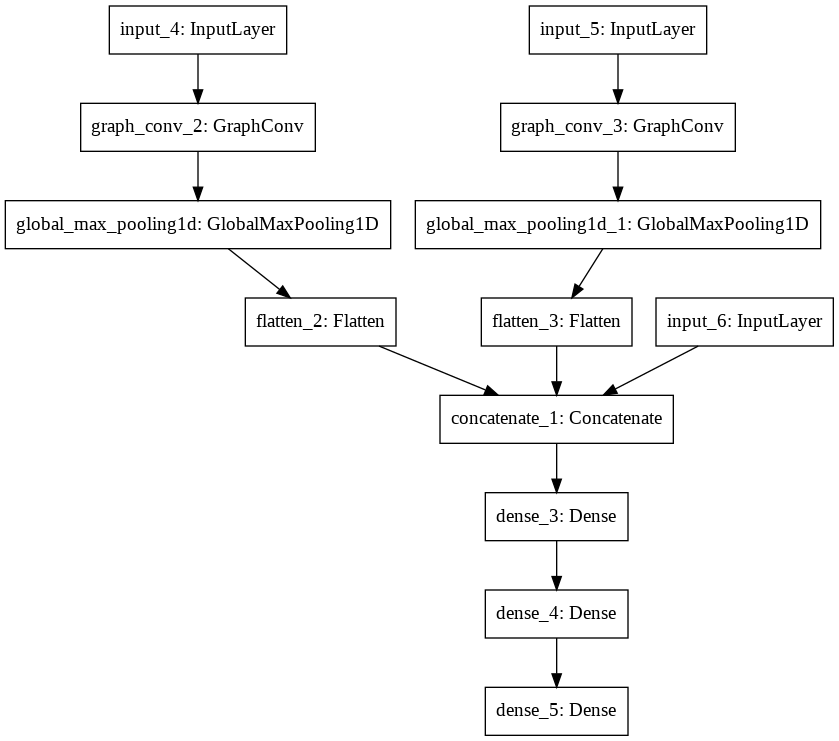

In [171]:
#drug structure_1
drug_01 = Input(shape=(96,5))
drug_01_layer1 = GraphConv(2,activation='relu')(drug_01)
drug_01_pool = tf.keras.layers.GlobalMaxPooling1D()(drug_01_layer1)
flat1 = Flatten()(drug_01_pool)

#drug structure_2
drug_02 = Input(shape=(96,5))
drug_02_layer1 = GraphConv(2,activation='relu')(drug_02)
drug_02_pool = tf.keras.layers.GlobalMaxPooling1D()(drug_02_layer1)
flat2 = Flatten()(drug_02_pool)

#target protein
flat3 = Input(shape=(494,))

#merge input models
merge = concatenate([flat1,flat2,flat3])

#interpretation model
# interpretation model
hidden1 = Dense(2000, activation='relu')(merge)
hidden2 = Dense(2000, activation='relu')(hidden1)
output = Dense(1)(hidden2)
model = Model(inputs=[flat3,drug_01,drug_02], outputs=output)
plot_model(model, to_file='multilayer_perceptron_graph.png')

In [172]:
def tune_nn_model(hp):
  #drug structure_1
  drug_01 = Input(shape=(96,5))
  drug_01_layer1 = GraphConv(2,activation='relu')(drug_01)
  drug_01_pool = tf.keras.layers.GlobalMaxPooling1D()(drug_01_layer1)
  flat1 = Flatten()(drug_01_pool)

  #drug structure_2
  drug_02 = Input(shape=(96,5))
  drug_02_layer1 = GraphConv(2,activation='relu')(drug_02)
  drug_02_pool = tf.keras.layers.GlobalMaxPooling1D()(drug_02_layer1)
  flat2 = Flatten()(drug_02_pool)

  #target protein
  flat3 = Input(shape=(494,))

  #merge input models
  merge = concatenate([flat1,flat2,flat3])

  #interpretation model
  hidden1 = Dense(units=hp.Int(
      'units',
       min_value=1000,
       max_value=5000,
       default=128
       ),
       activation=hp.Choice(
       'dense_activation',
       values=['relu', 'tanh', 'sigmoid']
       ))(merge)
  
  hidden1_D = Dropout(rate=hp.Float(
                'dropout_1',
                min_value=0.0,
                max_value=0.5,
                default=0.25
            ))(hidden1)

  hidden2 = Dense(units=hp.Int(
        'units_2',
        min_value=1000,
        max_value=5000,
        default=128
    ),
  activation=hp.Choice(
        'dense_activation_2',
        values=['relu', 'tanh', 'sigmoid']
    ))(hidden1_D)

  hidden2_D = Dropout(rate=hp.Float(
                'dropout_2',
                min_value=0.0,
                max_value=0.5,
                default=0.25
            ))(hidden2)

  output = Dense(1)(hidden2_D)

  model = Model(inputs=[flat3,drug_01,drug_02], outputs=output)
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Float('learning_rate',min_value=1e-5,max_value=1e-2,sampling='LOG',default=1e-3)),loss='mse',
                  metrics=['mse',correlation])
  return model

In [214]:
b_tuner =  BayesianOptimization(
    tune_nn_model,
    objective='mse',
    max_trials=1,
    executions_per_trial=100,
    seed=42,
    directory='tddduddsjsss2'
)

In [215]:
b_tuner.search_space_summary()

Search space summary
Default search space size: 7
units (Int)
{'default': 128, 'conditions': [], 'min_value': 1000, 'max_value': 5000, 'step': 1, 'sampling': None}
dense_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': None, 'sampling': None}
units_2 (Int)
{'default': 128, 'conditions': [], 'min_value': 1000, 'max_value': 5000, 'step': 1, 'sampling': None}
dense_activation_2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dropout_2 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': None, 'sampling': None}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [166]:
def correlation(x, y):    
    mx = tf.math.reduce_mean(x)
    my = tf.math.reduce_mean(y)
    xm, ym = x-mx, y-my
    r_num = tf.math.reduce_mean(tf.multiply(xm,ym))        
    r_den = tf.math.reduce_std(xm) * tf.math.reduce_std(ym)
    return r_num / r_den

In [216]:
b_tuner.search(x=[np.array(target_protein_df.iloc[:,2:496]),drug_structure_1_array,drug_structure_2_array],
             y=np.array(target_protein_df.iloc[:,496]),
             batch_size=64,
             epochs=30,
             validation_split=0.3)



Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
units             |3558              |?                 
dense_activation  |relu              |?                 
dropout_1         |0.20427           |?                 
units_2           |2088              |?                 
dense_activation_2|relu              |?                 
dropout_2         |0.17592           |?                 
learning_rate     |0.00044104        |?                 

Epoch 1/30
47/47 [==============================] - 6s 115ms/step - loss: 110.0617 - mse: 110.0617 - correlation: 0.2175 - val_loss: 99.9383 - val_mse: 99.9383 - val_correlation: 0.4319
Epoch 2/30
47/47 [==============================] - 5s 114ms/step - loss: 77.5532 - mse: 77.5532 - correlation: 0.5055 - val_loss: 99.3824 - val_mse: 99.3824 - val_correlation: 0.4467
Epoch 3/30
47/47 [==============================] - 5s 115ms/step - loss: 68.0632 - mse: 68.0632 - correlation: 0.5851 - val_loss: 92.2804 - val_m

In [210]:
b_tuner.results_summary()
best_hps = b_tuner.get_best_hyperparameters(num_trials = 1)[0]

Results summary
Results in tdduddsjsss2/untitled_project
Showing 10 best trials
Objective(name='mse', direction='min')
Trial summary
Hyperparameters:
units: 3558
dense_activation: relu
dropout_1: 0.20426793962724688
units_2: 2088
dense_activation_2: relu
dropout_2: 0.17592312791394132
learning_rate: 0.0004410354359965501
Score: 95.97606369018554


In [ ]:
# Build the model with the optimal hyperparameters and train it on the data
model = b_tuner.get_best_models(num_models=1)[0]

hist_train = model.fit(x=[np.array(target_protein_df.iloc[:,2:496]),drug_structure_1_array,drug_structure_2_array],
             y=np.array(target_protein_df.iloc[:,496]),
             batch_size=64,
             epochs=1,
             validation_split=0.3)

In [ ]:
dir(hist_train)

In [ ]:
hist_test = model.evaluate(X_test, y_test)

40/40 [==============================] - 1s 16ms/step - loss: 85.0177 - mse: 85.0177 - correlation: 0.5113


In [ ]:
hist_test

[85.01769256591797, 85.01769256591797, 0.5112579464912415]